# KNN Classisfication - Heart Disease

## Introduction
___

In [ ]:
# Install these libraries before continuing
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(repr)
library(GGally)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”


In [61]:
# Reading data from web (stored in github repo)
cleveland_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.cleveland.csv"
hungarian_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.hungarian.csv"
switzerland_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.switzerland.csv"
beach_url <-  "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.va.csv"

names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thanl", "num")

cleveland <- read_csv(cleveland_url, col_names = names)
hungarian <- read_csv(hungarian_url, col_names = names)
switzerland <- read_csv(switzerland_url, col_names = names)
beach <- read_csv(beach_url, col_names = names)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thanl
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thanl
dbl (5): age, sex, cp, oldpeak, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, fbs, restecg, thalach, exang, oldpeak, slope, ca, thanl
dbl (5): age, sex, cp, chol, num

ℹ Use `spec()` to r

In [62]:
# Changing all columns to doubles to be able to combine the 4 dataframes

cleveland <- mutate_all(cleveland, as.double)
hungarian <- mutate_all(hungarian, as.double)
switzerland <- mutate_all(switzerland, as.double)
beach <- mutate_all(beach, as.double)

heart_data_combined <- bind_rows(cleveland, hungarian, switzerland, beach)
heart_data_combined

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ca = .Primitive("as.double")(ca)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
Warning message:
“There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = .Primitive("as.double")(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 remaining warnings.”
Warning message:
“There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = .Primitive("as.double")(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 remaining warnings.”
Warning message:
“There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = .Primitive("as.double")(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see 

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thanl,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,1,4,122,223,1,1,100,0,0,NA,NA,6,2
58,1,4,NA,385,1,2,NA,NA,NA,NA,NA,NA,0
62,1,2,120,254,0,2,93,1,0,NA,NA,NA,1


In [63]:
clean_heart <- heart_data_combined |>
                mutate(num = ifelse(num %in% 1:4, 1, num)) |> # Correcting scaling of num
                filter(chol != 0) |> # There is one incorrect point where chol = 0
                mutate(num = as_factor(num)) |>
                select(age, chol, trestbps, thalach, oldpeak, num) |>
                filter(!is.na(age), !is.na(chol), !is.na(trestbps), !is.na(thalach), !is.na(oldpeak)) # Remove NAs

arrange(clean_heart, age)

age,chol,trestbps,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,132,130,185,0,0
29,204,130,202,0,0
29,243,120,160,0,0
⋮,⋮,⋮,⋮,⋮,⋮
76,197,140,116,1.1,0
77,304,125,162,0.0,1
77,171,124,110,2.0,1


In [64]:
# Split data into training (80%) and testing (20%) data
set.seed(1234)                    

heart_split <- initial_split(clean_heart, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

arrange(heart_train, age)
arrange(heart_test, age)

age,chol,trestbps,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,132,130,185,0,0
29,204,130,202,0,0
29,243,120,160,0,0
⋮,⋮,⋮,⋮,⋮,⋮
76,197,140,116,1.1,0
77,304,125,162,0.0,1
77,171,124,110,2.0,1


age,chol,trestbps,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
30,237,170,170,0,0
31,219,100,150,0,0
32,225,110,184,0,0
⋮,⋮,⋮,⋮,⋮,⋮
68,193,144,141,3.4,1
69,216,122,84,0.0,1
70,192,170,129,3.0,1


### Preliminary Analysis

In [2]:
# Plots visualizing distribution of each variable, separated by diagnosis of heart disease
options(repr.plot.width = 15) # Alter to fit screen

# Renaming num (plots only to make the legend clearer
heart_train_renamed_num <- heart_train |>
                            mutate(diagnosis = case_when(
                                num == 0 ~ "No Heart Disease(<50% diameter narrowing)",
                                num == 1 ~ "Heart Disease (> 50% diameter narrowing)"
                            ))

y_lab = "Number of People"
leg_lab = "Heart Disease Diagonis"
text_size = 15

plot_age <- ggplot(heart_train_renamed_num, aes(x = age)) +
    geom_histogram(aes(fill = diagnosis)) +
    labs(x = "Age (Years)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    ggtitle("Distribution of Age (Predictor) Separated by Heart Disease Diagnosis") +
    theme(text = element_text(size = text_size))

plot_chol <- ggplot(heart_train_renamed_num, aes(x = chol)) +
    geom_histogram(aes(fill = diagnosis)) +
    labs(x = "Serum Cholestoral (mg/dl)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    ggtitle("Distribution of Cholesterol Levels (Predictor) Separated by Heart Disease Diagnosis") +
    theme(text = element_text(size = text_size))

plot_trestbps <- ggplot(heart_train_renamed_num, aes(x = trestbps)) +
    geom_histogram(aes(fill = diagnosis)) +
    labs(x = "Resting Blood Pressure (mmHg)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    ggtitle("Distribution of Resting Blood Pressure (Predictor) Separated by Heart Disease Diagnosis") +
    theme(text = element_text(size = text_size))

plot_thalach <- ggplot(heart_train_renamed_num, aes(x = thalach)) +
    geom_histogram(aes(fill = diagnosis)) +
    labs(x = "Maximum Heart Rate (bpm)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    ggtitle("Distribution of Maximum Heart Rate (Predictor) Separated by Heart Disease Diagnosis") +
    theme(text = element_text(size = text_size))

plot_oldpeak <- ggplot(heart_train_renamed_num, aes(x = oldpeak)) +
    geom_histogram(aes(fill = diagnosis)) +
    labs(x = "ST Depression Induced by Exercise Relative to Rest (Ratio)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    theme(text = element_text(size = text_size)) +
    ggtitle("Distribution of ST Depression Induced by Exercise Relative to Rest (Predictor) Separated by Heart Disease Diagnosis") 

plot_age
plot_chol
plot_trestbps
plot_thalach
plot_oldpeak

ERROR: Error in mutate(heart_train, diagnosis = case_when(num == 0 ~ "No Heart Disease(<50% diameter narrowing)", : could not find function "mutate"


### KNN Classification

In [66]:
# Recipe (standardization)
set.seed(1234)

heart_recipe <- recipe(num ~ ., data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Define model specification - tune neighbors using 5-fold cross validation
heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 5, strata = num)
vals <- tibble(neighbors = seq(from = 1, to = 20))

heart_accuracy <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_tune) |>
    tune_grid(resamples = heart_vfold, grid = vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(neighbors)

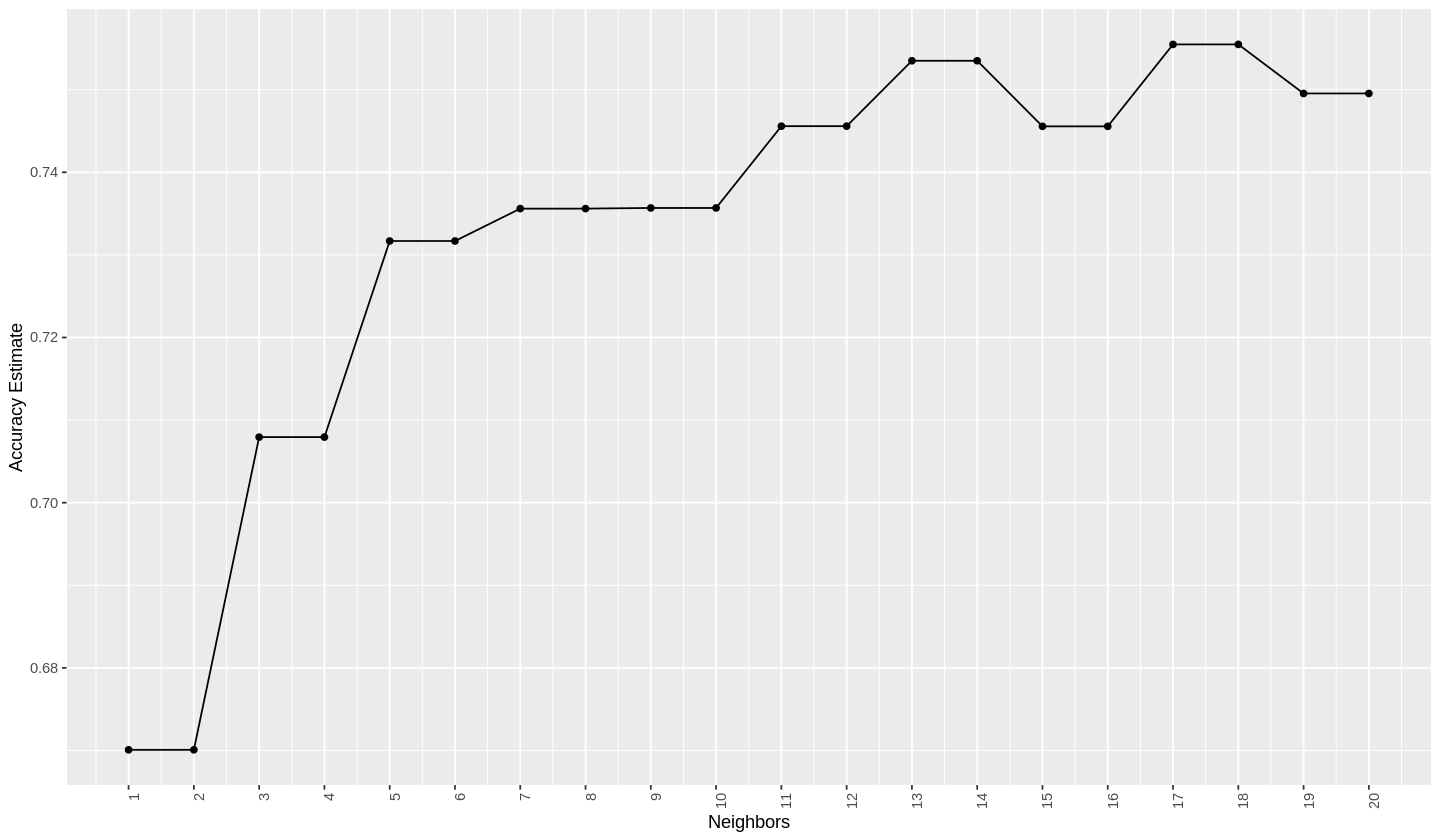

In [67]:
# Generate graph of accuracy
options(repr.plot.width = 12)
k_accuracies <- ggplot(heart_accuracy, aes(x = neighbors, y = mean)) +
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 100, by = 1)) +
       theme(axis.text.x = element_text(angle = 90, hjust = 1))

k_accuracies

In [ ]:
heart_predictors <- heart_train |>
                    select(age, chol, trestbps, thalach, oldpeak)
        
heart_means <- map_df(heart_predictors, mean)
heart_means

In [ ]:
# Maximum
heart_max <- heart_predictors |>
                    map_df(max)
heart_max

In [ ]:
# Minimum
heart_min <- heart_predictors |>
                    map_df(min)
heart_min

In [ ]:
heart_obs <- heart_train |>
                group_by(num) |>
                summarize(num_count = n())

heart_obs

In [68]:
# Determine best k

best_k <- heart_accuracy |>
    arrange(-mean) |>
    slice(1) |>
    select(neighbors) |>
    pull()

best_k

best_train_accuracy <- heart_accuracy |>
    summarize(accuracy = max(mean)) |>
    pull()

percent(best_train_accuracy)

[1] 17

[1] "76%"

In [69]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_resample_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit(data = heart_train)

heart_resample_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(17L,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2564612
Best kernel: rectangular
Best k: 17

In [70]:
# Prediction on the testing data
heart_test_predict = predict(heart_resample_fit, heart_test)|>
    bind_cols(heart_test)

# heart_train_resample_predict
heart_test_accuracy <- metrics(data = heart_test_predict, truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy")|>
    pull()

heart_test_accuracy

[1] 0.6923077

In [77]:
# Cross Validation Plot
confusion <- heart_test_predict |>
             conf_mat(truth = num, estimate = .pred_class)

confusion

precision <- heart_test_predict |>
            precision(truth = num, estimate = .pred_class, event_level = "first")

recall <- heart_test_predict |>
            recall(truth = num, estimate = .pred_class, event_level = "first")

precision
recall

          Truth
Prediction  0  1
         0 75 38
         1 14 42

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.6637168


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.8426966


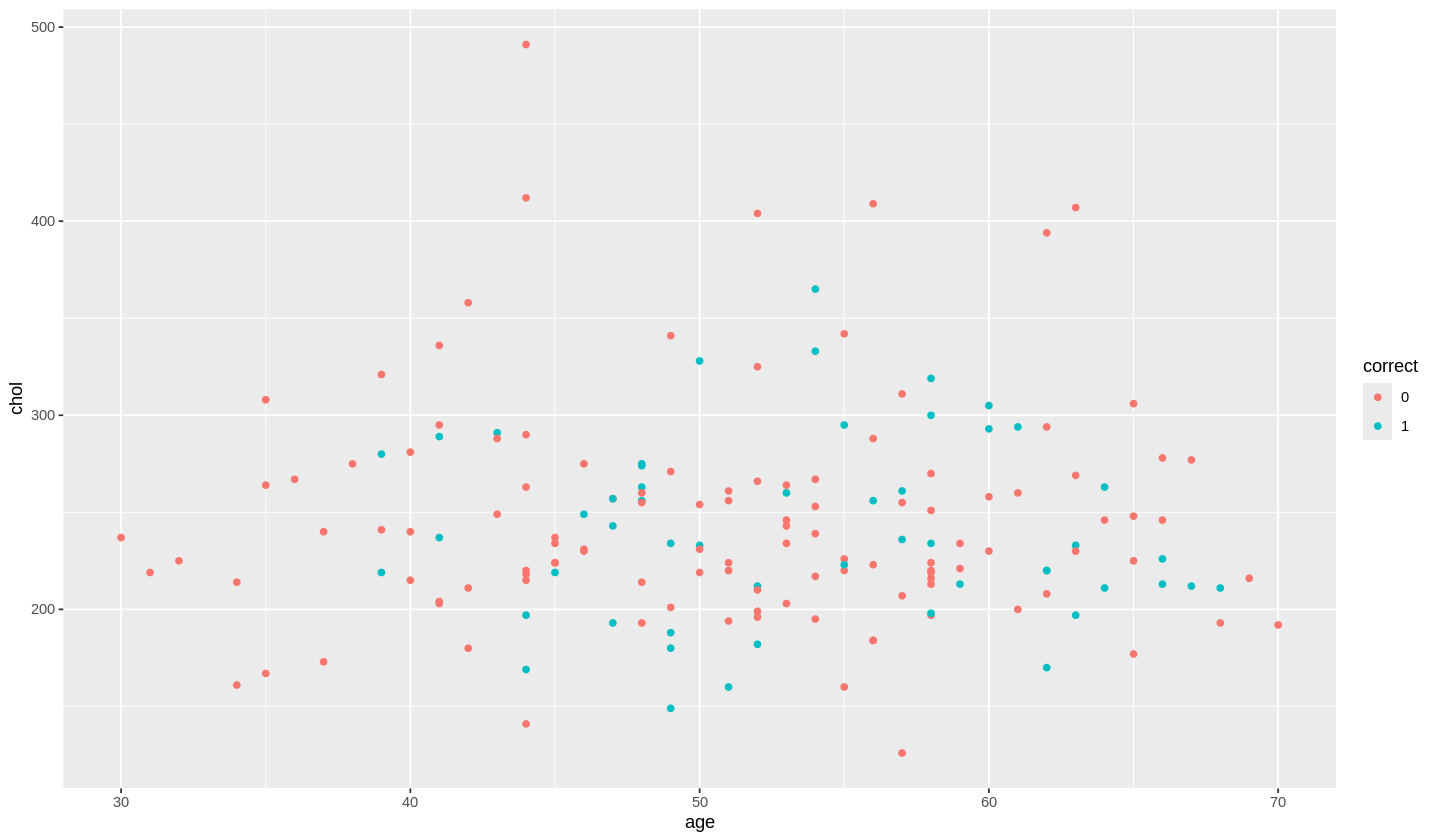

In [78]:
## Testing additional ideas about how to plot!
library(class)
heart_correct <- heart_test_predict |>
                    mutate(correct = as.integer(num) - as.integer(.pred_class)) |>
                    mutate(correct = as.factor(ifelse(correct == 0, 0, 1)))

heart_correct_plot <- heart_correct |>
    ggplot(aes(x = age, y = chol)) +
    geom_point(aes(color = correct))

heart_correct_plot

## Citations

Janosi, A., Steinbrunn, W., Pfisterer, M., Detrano, R. Heart Disease UCI Machine Learning Repository [Data set]. https://doi.org/10.24432/C52P4X

Jousilahti, P., Vartiainen, E., Tuomilehto, J., Puska, P. Sex, Age, Cardiovascular Risk Factors, and Coronary Heart Disease. (1999). Circulation, 99, 1165-1172. https://doi.org/10.1161/01.CIR.99.9.1165

Bobbio, M., Detrano, R., Schmid, J., Janosi, A., Righetti, A., Steinbrunn, W., Guppy, K., Abi-Mansour, P., Deckers, J., Colombo, A., Lehmann, K., Olson, H. (1992). Exercise-induced ST depression and ST/heart rate index to predict triple-vessel or left main coronary disease: A multicenter analysis. Journal of American College of Cardiology, 19(1), 11-18. https://doi.org/10.1016/0735-1097(92)90044-N

Heart Disease and Stroke. (2022 8 September). CDC. https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#:~:text=The%20Nation's%20Risk%20Factors%20and,unhealthy%20diet%2C%20and%20physical%20inactivity.

Citations and in-text citations excluded from word coun